# Advanced droughts workflow

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=DROUGHTS_notebook_1.ipynb) to launch this workflow on MyBinder. 

This template workflow should help us make sure that all the notebooks have the same structure.  
The green 'tip' boxes are there with the example text. **Make sure you delete them when you add your own text**.

Useful links:

- [Jupyter book documentation](https://jupyterbook.org/en/stable/intro.html)
- [MyST Markdown documentation](https://myst-parser.readthedocs.io/en/latest/index.html)

## Risk assessment methodology

This methodology is for assessing drought risk and it is based on [Carrão et al. (2016)](https://doi.org/10.1016/j.gloenvcha.2016.04.012). This paper produced a risk map which indicates the probability of harmful consequences from the interactions (i.e., multiplication) between drought hazards, exposure, and vulnerability, by normalizing the regional scores to a scale ranging between zero to one (one indicating the highest drought risk). For the purposes of this toolbox, we plan to follow Carrão et al. (2016) work, reproducing the drought risk map for the European Union at NUTS2 spatial resolution, for both historical (1960 -2019), and future scenarios (2020 -2100).

### Drought hazard indices

Hazard indicators Drought hazard (dh) for a given region is estimated as the probability of exceedance the median of global severe precipitation deficits for an historical reference period (1960 -2019). [Carrão et al. (2016)](https://doi.org/10.1016/j.gloenvcha.2016.04.012) use the weighted anomaly of standardized precipitation (WASP) index to define the severity of precipitation deficit. The WASP-index takes into account the annual seasonality of precipitation cycle and is computed by summing weighted standardized monthly precipitation anomalies (Lyon and Barnston, 2005).

Daily global gridded climate related forcings are available from the GSWP3-W5E5 dataset (ISIMIP3a; ISIMIP Repository https://doi.org/10.48364/ISIMIP.982724.1) at a 0.5-degree spatial resolution, covering the years 1901 -2019. The period between 2020 -2100, will be covered by five different simulated biased-adjusted atmospheric climate (GFDL-ESM4, IPSL-CM6A-LR, MPI-ESM1-2-HR, MRI-ESM2-0, UKESM1-0-KK) and three different RCPs (2.6, 7.0, and 8.5).

### Drought exposure indices

A non-compensatory model of drought exposure is used to estimate the potential losses from different types of drought disasters at different geographic regions. It accounts for the spatial distribution of crop areas and livestock (agricultural drought), water stress (hydrological drought), and human population (socioeconomic drought). This approach defines highly exposed regions in case at least one type of asset is abundant. For that purpose, we will use data envelopment analysis (DEA), which determines the relative exposure of each region to drought by its statistical positioning and normalized multivariate distance to a performance frontier.

We will use the following datasets for the exposure indicator: • Gridded global cropland at 5 arc minutes resolution for 2010 (Spatial Production and Allocation model; IFPRI, 2019 https://doi.org/10.7910/DVN/PRFF8V). • Gridded global livestock density at 5 arc minutes resolution for 2010 (The global gridded livestock of the world, GLW; Gilbert et al., 2018 https://data.apps.fao.org/catalog/dataset/glw). • Global sub-basin scale/gridded baseline water stress (BWS) can be taken as an historical average from Aqueduct 3 (source https://doi.org/10.46830/writn.18.00146) or calculated based on the Global ISIMIP3 CWatM simulations (Burek et al., 2020). • Gridded global population at 2.5 arc minutes resolution for 2015 (the Gridded Population of the World; Doxsey-Whitfield, et al., 2015 https://doi.org/10.7927/H45Q4T5F).

### Drought vulnerability indices

Vulnerability to drought is computed as a 2-step composite model that derives from the aggregation of proxy indicators representing the economic, social, and infrastructural factors of vulnerability at each geographic location, as similar as for the Drought Vulnerability Index (DVI). A possible source for indicators can be World Bank https://data.worldbank.org/.

In the first step, indicators for each factor are combined using a DEA model, as similar as for drought exposure. In the second step, individual factors resulting from independent DEA analyses are arithmetically aggregated (using the simple mean) into a composite model of drought vulnerability (dv).

Describe where the data can be found, is there an API to download it or the files can be downloaded from some data repository. Provide a link to the repository (as DOI if possible).
wnload it or the files can be downloaded from some data repository. Provide a link to the repository (as DOI if possible).

## Preparation work

### Load libraries

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pandas](https://pandas.pydata.org/docs/user_guide/index.html) - To create and manage data frames (tables) in Python
- [jenkspy](https://github.com/mthh/jenkspy) - To apply Fisher-Jenks alogrithm to classify drought/non-drought periods
- [numpy](https://numpy.org/doc/stable/) - For basic math tools and operations
- [matplotlib](https://matplotlib.org/) - For plotting
- [scipy](https://scipy.org/) - Provide optimization capacities for the Data Envelopment Analysis (DEA)
- [envelopmentpy.envelopment](https://github.com/metjush/envelopment-py/tree/master) - An adapted script to perform DEA


#### Template dep.

- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - To calculate the damage maps
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps


In [6]:
import os
import pandas as pd
import jenkspy
import numpy as np
import matplotlib.pyplot as plt
import scipy


# adapted from https://github.com/metjush/envelopment-py/tree/master
from envelopmentpy.envelopment import *

'''
# template dependencies below.
import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
'''

## Functions ##

def calculate_monthly_threshold(x, m, col_idx):
    idx = (x['timing'].str.contains(m))
    mon_loc_subset = precip.iloc[idx[idx].index, col_idx]
    return(jenkspy.jenks_breaks(mon_loc_subset, n_classes = 2)[1])

def identify_monthly_drought(x, m, col_idx, thrs):
    idx = (x['timing'].str.contains(m))
    x.iloc[idx[idx].index, col_idx] = x.iloc[idx[idx].index, col_idx] < thrs
    return(x)

def identify_t_m(k, m):
    if 'Jan' in precip.iloc[k, 0]: 
        return(int(0))
    if 'Feb' in precip.iloc[k, 0]:
        return(int(1))
    if 'Mar' in precip.iloc[k, 0]:
        return(int(2))
    if 'Apr' in precip.iloc[k, 0]:
        return(int(3))
    if 'May' in precip.iloc[k, 0]:
        return(int(4))
    if 'Jun' in precip.iloc[k, 0]:
        return(int(5))
    if 'Jul' in precip.iloc[k, 0]:
        return(int(6))
    if 'Aug' in precip.iloc[k, 0]:
        return(int(7))
    if 'Sep' in precip.iloc[k, 0]:
        return(int(8))
    if 'Oct' in precip.iloc[k, 0]:
        return(int(9))
    if 'Nov' in precip.iloc[k, 0]:
        return(int(10))
    if 'Dec' in precip.iloc[k, 0]:
        return(int(11))


### Define working environment and global parameters
This workflow relies on pre-procssed data. The user will define the path to the data folder and the code below would create a folder for outputs.


In [7]:
workflow_folder = './sample_data/'

# debug if folder does not exist - issue an error to check path

# create outputs folder
if not os.path.exists(os.path.join(workflow_folder, 'outputs')):
    os.makedirs(os.path.join(workflow_folder, 'outputs'))

# globals
regions = ['RID1', 'RID2', 'RID3']
rcolors = ['#579fe1', '#E19957', '#57e199']
monthString = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

### Loading precipitation data and calculate hazard indices

Input precipitation data (top 3 rows): 
   timing  RID1  RID2  RID3
0  Jan-90   169   370   626
1  Feb-90   230   282   416
2  Mar-90   111   265   613


Input precipitation line chart: 


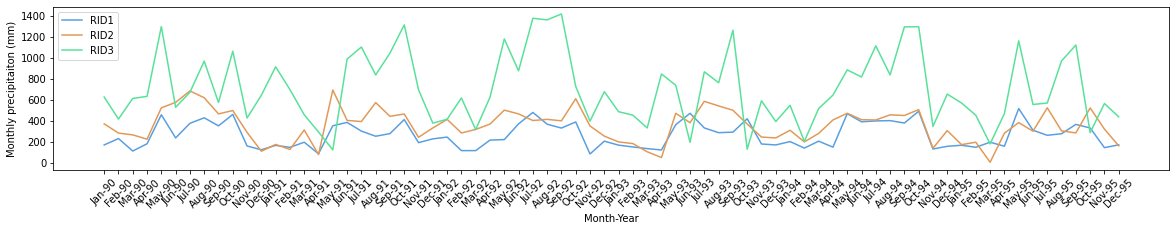

In [8]:
# Load precipitation data
precip = pd.read_csv(os.path.join(workflow_folder, "P_sample.csv"))


# show data

print('Input precipitation data (top 3 rows): ')
print(precip.head(3))

#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
print('\n')
print('Input precipitation line chart: ')

plt.rcParams["figure.figsize"] = (20,3)
fig, ax = plt.subplots()
plt.xticks(rotation = 45) 
ax.plot(precip['timing'].tolist(), precip['RID1'].tolist(), label = 'RID1', color = rcolors[0])
ax.plot(precip['timing'].tolist(), precip['RID2'].tolist(), label = 'RID2', color = rcolors[1])
ax.plot(precip['timing'].tolist(), precip['RID3'].tolist(), label = 'RID3', color = rcolors[2])
ax.legend(loc = 'upper left')

plt.xlabel("Month-Year")
plt.ylabel("Monthly precipitaiton (mm)")

plt.show()

## calculate WASP Index monthly threshold

WASP = []
WASP_global = []

### create a multi-dimensional array for monthly thresholds

drought_class = precip.copy()

# prepare output for drought event index - WASP_j- list of lists wasp = [[rid1], [rid2], ...]
for i in range(1, len(precip.columns)):
    t_m = []
    for mon_ in monthString:
        t_m_last = calculate_monthly_threshold(x = precip, m = mon_, col_idx = i)
        t_m.append(t_m_last)
        drought_class = identify_monthly_drought(x = drought_class, m = mon_, col_idx = i, thrs = t_m_last)
    
    # calculate annual threshold & count droughts
    t_a = sum(t_m)

    WASP_tmp = []
    first_true=0
    index = []
    for k in range(1, len(precip)):
        if drought_class.iloc[k, i]== 1:
            if first_true==0:                               
                index = identify_t_m(k = k, m = mon_)
                WASP_last=((precip.iloc[k,i] - t_m[index])/t_m[index])* (t_m[index]/t_a)
                WASP_tmp.append(WASP_last)
                first_true=1
            else:                         
                index_last = identify_t_m(k = k, m = mon_) 
                WASP_last=((precip.iloc[k,i] - t_m[index])/t_m[index])* (t_m[index]/t_a)
                WASP_tmp[-1]=WASP_tmp[-1] + WASP_last
            WASP_global.append(WASP_last)
        else:
            first_true=0
    WASP.append(np.array(WASP_tmp))
       

# calculate the exceedance probability from the median global WASP as the Hazard index (dH)

dH = []
WASP = np.array(WASP, dtype=object)

# calculate global median deficit severity
median_global_wasp = np.nanmedian(WASP_global)

# calculate dH per region i
for i in range(WASP.shape[0]):
    dH.append(round(1 - np.nansum(WASP[i] <= median_global_wasp) / len(WASP[i]), 3))


In [11]:
# Load exposure data
exposure = pd.read_csv(os.path.join(workflow_folder, "E_sample.csv"))


# show data

print('Input exposure data (top 3 rows): ')
print(exposure)

# see tutorial dea: http://deazone.com/en/resources/tutorial/abstract

# set DEA(loud = True) to print optimization status/details
dea_e = DEA(exposure.to_numpy()[0:3, 1:4],\
          np.array([1000.,1000.,1000.]).reshape(3,1),\
         loud = False)
dea_e.name_units(['RID1', 'RID2', 'RID3'])

# returns a list with regional efficiencies
dE = dea_e.fit()  

Input exposure data (top 3 rows): 
  Country_Name   Exposure_1  Exposure_2  Exposure_3
0         RID1  1790.348800       10.52       33.62
1         RID2  2998.501158       32.74       52.33
2         RID3  6802.804519        5.53        9.05


In [16]:
# Load exposure data
vulnerability = pd.read_csv(os.path.join(workflow_folder, "V_sample.csv"))

# show data

print('Input vulnerability data (top 3 rows): ')
print(vulnerability.head(3))

factorsString = ['Social', 'Economic', 'Infrast']
d_v = []      

for fac_ in factorsString:
    factor_subset = vulnerability.loc[:, vulnerability.columns.str.contains(fac_)]
    dea_v = DEA(factor_subset.to_numpy()[0:3, 1:4],\
          np.array([1000.,1000.,1000.]).reshape(3,1),\
          loud = False)
    dea_v.name_units(['RID1', 'RID2', 'RID3'])

# returns three lists with regional efficiencies for each factor
    d_v_last = dea_v.fit()  
    d_v.append(d_v_last)
    
dV = np.nanmean(np.array(d_v), axis = 0)




Input vulnerability data (top 3 rows): 
  Country_Name  Social_1  Social_2  Social_3  Economic_1  Economic_2  \
0         RID1   1820.34     37.98    546.45         313       65.36   
1         RID2   3552.20     25.25    694.25         171       47.36   
2         RID3   5241.98      5.55    983.47         158       25.39   

   Economic_3  Infrastructural_1  Infrastructural_2  Infrastructural_3  
0        0.25              30.25              54.25            4563.25  
1        0.49              70.36              65.36            4587.34  
2        0.36              23.01              47.65            8963.54  


In [18]:
#calculate the Risk Index for each region

# Risk = Hazard * Exposure * Vulnerability

R= []

print ('Hazard indices for the three regions:')
print(dH)
print('\n')
print ('Exposure indices for the three regions:')
print(dE)
print('\n')
print ('Vulnerability indices for the three regions:')
print(dV)
print('\n')

for i in range(0, len(regions)):
        R_last = round(dH[i] * dE[i] * dV[i], 3)
        R.append(R_last)

print ('Risk indices for the three regions:')
print (R)



Hazard indices for the three regions:
[0.357, 0.5, 0.235]


Exposure indices for the three regions:
[1.0, 0.633, 1.0]


Vulnerability indices for the three regions:
[1.    0.896 1.   ]


Risk indices for the three regions:
[0.357, 0.284, 0.235]


### Plot results



Hazard indices: 


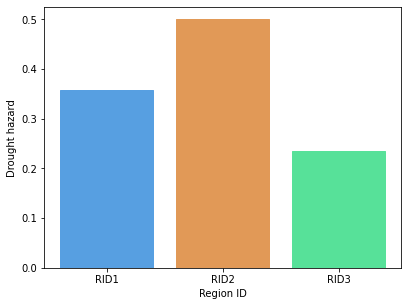

Exposure indices: 


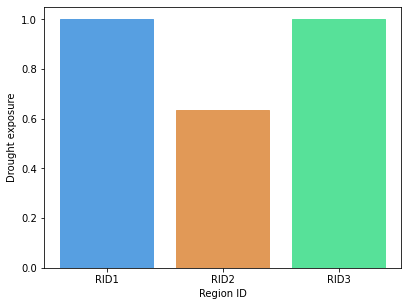

Vulnerability indices: 


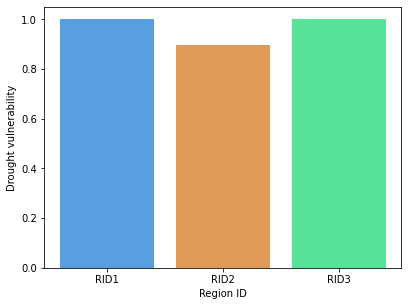

Drought risk: 


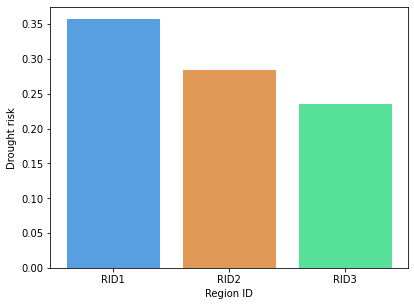

3D plot: 


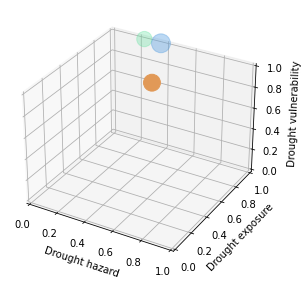

In [39]:
print('\n')
print('Hazard indices: ')

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
barlist = plt.bar(['RID1', 'RID2', 'RID3'], dH)
for i in range(3):
    barlist[i].set_color(rcolors[i])
plt.xlabel("Region ID")
plt.ylabel("Drought hazard")

plt.show()

print('Exposure indices: ')

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
barlist = plt.bar(['RID1', 'RID2', 'RID3'], dE)
for i in range(3):
    barlist[i].set_color(rcolors[i])
plt.xlabel("Region ID")
plt.ylabel("Drought exposure")

plt.show()

print('Vulnerability indices: ')

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
barlist = plt.bar(['RID1', 'RID2', 'RID3'], dV)
for i in range(3):
    barlist[i].set_color(rcolors[i])
plt.xlabel("Region ID")
plt.ylabel("Drought vulnerability")

plt.show()

print('Drought risk: ')

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
barlist = plt.bar(['RID1', 'RID2', 'RID3'], R)
for i in range(3):
    barlist[i].set_color(rcolors[i])
plt.xlabel("Region ID")
plt.ylabel("Drought risk")

plt.show()

print('3D plot: ')
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel('Drought hazard')
ax.set_ylabel('Drought exposure')
ax.set_zlabel('Drought vulnerability')

ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)
ax.set_zlim(0., 1.)

ax.scatter(dH, dE, dV, s = [x * 1000 for x in R], c = rcolors)

#plt.show()

## Conclusions

Some text about conclusions and lessons learned

## Contributors
The workflow has beend developed by [Silvia Artuso](https://iiasa.ac.at/staff/silvia-artuso) and [Dor Fridman](https://iiasa.ac.at/staff/dor-fridman) from [IIASA's Water Security Research Group](https://iiasa.ac.at/programs/biodiversity-and-natural-resources-bnr/water-security).